# iShame Coffee Video Pre-Processing

This notebook walks through the process to prepare training and test data for the iShame CNN model. Training data consists of videos of coffee pots in various states of fullness. Videos are decomposed in to invidual frames and associated with the appropriate label. Data is then split in to train and test sets, and saved in h5 format.

In [6]:
import os
import glob
import json
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import h5py
import cv2
from random import randint

First, we retrieve the set of videos in the input folder, which are saved with their class label. We create a dictionary assocating the file path to the video with the appropriate label. Then, we use build a dictionary to label encode the possible classes. We also set a flag for whether the expected values are one-hot encoded classes or the range of coffee pot fullness (0.0 - 1.0).

In [7]:
is_regression = False


In [8]:
video_dir = '/c/Users/rrr0901/Documents/Workspace/iShame/data/coffee_video/raw/v2'
videos = []
labels = set()
for video in glob.glob(os.path.join(video_dir,"*.mp4")):
    label = os.path.splitext(os.path.basename(video))[0]
    path = video
    videos.append({"label": label, "path": path})
    labels.add(label)

labels = sorted(labels)
label_dict = {idx:label for idx,label in enumerate(labels)}
reverse_label_dict = {label:idx for idx,label in enumerate(labels)}
print(labels)

['0.0', '0.25', '0.291', '0.458333', '0.625', '0.8333']


For each video, we decompose it in to its individual frames. For each frame, we load it as a numpy array using OpenCV, then resize it. Then, we attach the numpy array and the label to the image_data and image_labels arrays. Image data is also normalized in this step.

All frame pre-processing would occur in this step. Potential transformations that we are considering include conversion to HSV color space (instead of RGB), resizing, adding noise, etc.

In [9]:
import preprocess_images

def process_videos(videos, image_data, image_labels):

    for video in videos:

        vidcap = cv2.VideoCapture(video['path'])
        label = video['label']
        label_enc = reverse_label_dict[label]

        count = 0
        save_every_n = 1
    
        success, image = vidcap.read()

        while success:

            if count % save_every_n == 0:
                
                image = preprocess_images.preprocess_image(image)

                image_data.append(image)

                if(is_regression):
                    image_labels.append(float(label))
                else:
                    image_labels.append(label_enc)
    
            count += 1
            success, image = vidcap.read()



In [10]:
image_data = []
image_labels = []

process_videos(videos, image_data, image_labels)

Let's check the dimensions of our image data and labels. Each image has the dimensions (height, width, channels).

In [12]:
print("Image Data Examples:",len(image_data))
print("Number of Image Labels:",len(image_labels))
print("Image Dimensions:", image_data[0].shape)
print("Last Image:",image_data[-1])
print("Last Image Label:",image_labels[-1])


Image Data Examples: 2310
Number of Image Labels: 2310
Image Dimensions: (540, 960, 3)
Last Image: [[[0.42352941 0.45882353 0.45490196]
  [0.42352941 0.45882353 0.45490196]
  [0.42352941 0.45098039 0.44705882]
  ...
  [0.34117647 0.47058824 0.58431373]
  [0.32941176 0.45882353 0.57254902]
  [0.3254902  0.45490196 0.56862745]]

 [[0.41568627 0.45098039 0.44705882]
  [0.41568627 0.45098039 0.44705882]
  [0.41960784 0.44705882 0.44313725]
  ...
  [0.3372549  0.46666667 0.58039216]
  [0.32156863 0.45098039 0.56470588]
  [0.32156863 0.45098039 0.56470588]]

 [[0.41960784 0.45490196 0.45098039]
  [0.41568627 0.45098039 0.44705882]
  [0.41960784 0.44705882 0.44313725]
  ...
  [0.33333333 0.4627451  0.57647059]
  [0.32941176 0.45882353 0.57254902]
  [0.32941176 0.45882353 0.57254902]]

 ...

 [[0.2        0.19215686 0.16862745]
  [0.18823529 0.18039216 0.15686275]
  [0.18039216 0.17254902 0.14901961]
  ...
  [0.21568627 0.35294118 0.50196078]
  [0.22352941 0.36078431 0.50980392]
  [0.22745098 

Let's look at a random image and its label.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(540, 960, 3)


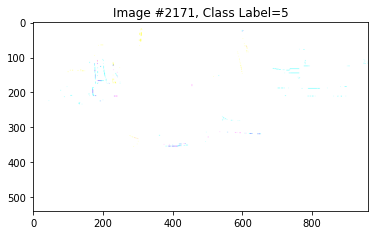

In [18]:
idx = randint(0,len(image_data))
plt.title('Image #' + str(idx) + ', Class Label=' + str(image_labels[idx]))
image = 255*image_data[idx]
print(image.shape)
plt.imshow(image)

We use scikit-learn's "train_test_split" method to split our data set in to train (80%) and test (20%) sets. 

In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(image_data, image_labels, test_size=0.2, shuffle=True, random_state=42)
print(len(train_data),len(train_labels))
print(len(test_data),len(test_labels))

1848 1848
462 462


We concatenate the training data and test data in to a single numpy array (instead of a list of numpy arrays). The training and test data now have the dimensions (number of example, width, height, channels)

In [10]:
train_data = np.stack(train_data, axis=0)
print(train_data.shape)

test_data = np.stack(test_data, axis=0)
print(test_data.shape)

(1848, 540, 960, 3)
(462, 540, 960, 3)


We normalize the data to scale from the range of (0-255) to (0-1). 

In [11]:
idx = randint(0,len(train_data))
print("Random Image Before Scaling:",train_data[idx][0,0,:])

train_data = train_data/255.
test_data = test_data/255.

print("Random Image After Scaling:",train_data[idx][0,0,:])


Random Image Before Scaling: [123 127 127]
Random Image After Scaling: [0.48235294 0.49803922 0.49803922]


We convert our class labels to be one-hot encoded. Alternatively, we could train the output using the estimated "fullness" of the coffee pot in the range of 0-1 and treat this as a regression problem.

In [12]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


if(is_regression):
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
else:
    train_labels = convert_to_one_hot(np.array(train_labels,ndmin=2),len(labels))
    test_labels = convert_to_one_hot(np.array(test_labels,ndmin=2),len(labels))

print(train_labels.shape)
print(test_labels.shape)

print(train_labels[0])
print(test_labels[19])



(1848, 6)
(462, 6)
[0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0.]


Finally we save our train and test data / labels in a single h5 file.

In [13]:
data_save_path = '../../data/coffee_video/label_data/v3'

if is_regression:
    data_set_name='coffee_regression_data_v3.h5'
else:
    data_set_name='coffee_class_data_v3.h5'


In [14]:
filepath=os.path.join(data_save_path,data_set_name)

if(os.path.exists(filepath)):
    os.remove(filepath)

if(not os.path.exists(data_save_path)):
    os.makedirs(data_save_path)

coffee_data = h5py.File(filepath,'w')
coffee_data.create_dataset('train_data', data=train_data)
coffee_data.create_dataset('test_data', data=test_data)
coffee_data.create_dataset('train_labels', data=train_labels)
coffee_data.create_dataset('test_labels', data=test_labels)
coffee_data.close()
